# HR Churn - Eindwerk Data Science 2023-24 - Raf Ledeganck

## Imports

<i>(Development on Tensorflow 2.11.0 Docker Container)</i>

In [1]:
!pip install scikit-learn
#!pip install scikit-image
!pip install pandas
!pip install seaborn
!pip install scikit-optimize
!pip install imbalanced-learn
!pip install scikeras

     |████████████████████████████████| 11.1 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 3.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 12.4 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 505 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 5.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 294 kB 3.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 107 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 736 kB 4.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

# Sklearn
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scipy
from scipy import stats

# Tensorflow, Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from scikeras.wrappers import KerasClassifier

In [3]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#import sklearn
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import OneHotEncoder, StandardScaler
#from sklearn.decomposition import PCA
#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
from IPython.display import display_html 

## Functions

In [5]:
def agg_feat_imp(df_feat_imp):

    df_abs = df_feat_imp.abs().copy()

    # Calculate total correlation per feature rather than by OneHotEncoder split
    lst_row= ['MANAGER', 'DEPARTMENT', 'DPT_CHANGE_FLAG', 'COMPANY', 'SITE', 'FULL_TIME', 'EMPLOYEE_LEVEL', 'HANDICAP', 'CITIZENSHIP']
    for row in lst_row:
        prefix = 'cat__' + row

        # Add row with total correlation
        df_abs.loc[row] = df_abs.filter(regex=prefix, axis='index').sum().values[0]

        # Remove rows with correlations for individual OneHotEncoder splits
        df_abs.drop(list(df_abs[df_abs.index.str.startswith(prefix)].index), axis='index', inplace=True)

    # Remove prefixes from row names
    dict_rownames = {}
    for row in df_abs.index:
        if row.find('__') > 0:
            dict_rownames[row] = row[ (row.find('__')+2) : ]

    df_abs.rename(index=dict_rownames, inplace=True)

    return(df_abs)

In [6]:
def plot_feat_imp(df_feat_imp, export=False, file_name='plot.jpg', show=True):

    # Sort from high to low importance
    df_feat_imp.sort_values('Importance', ascending=False, inplace=True)

    # Generate plot
    fig, ax = plt.subplots(figsize=(12,6),dpi=100)
    sns.barplot(df_feat_imp, x=df_feat_imp.index, y=df_feat_imp['Importance'])
    plt.xticks(rotation=90)

    # Export plot
    if export:
        plt.savefig(file_name, bbox_inches='tight')

    # Print plot
    if show:
        plt.show()
    
    plt.close(fig);

## Data

In [7]:
df_train_raw = pd.read_csv('../Data/Employee_Churn_train.csv', sep=';')
df_train_raw.head()

FileNotFoundError: [Errno 2] No such file or directory: '../Data/Employee_Churn_train.csv'

### Data Exploration

In [ ]:
df_train_raw.describe()

In [6]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4741 entries, 0 to 4740
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Employee ID                 4741 non-null   int64  
 1   NAME                        4741 non-null   object 
 2   FIRST_NAME                  4741 non-null   object 
 3   GENDER                      4741 non-null   object 
 4   MANAGER                     4710 non-null   float64
 5   EMPLOYEE_TYPE               4741 non-null   object 
 6   DEPARTMENT                  4741 non-null   int64  
 7   DPT_CHANGE_FLAG             4741 non-null   object 
 8   JOB                         4741 non-null   object 
 9   STATUS                      4741 non-null   object 
 10  COMPANY                     4741 non-null   int64  
 11  SITE                        4741 non-null   object 
 12  PERMANENT                   4741 non-null   object 
 13  EMPLOYEE_CLASS              4621 

In [7]:
for col in df_train_raw.columns:
    if not df_train_raw[col].dtype.kind in 'iuf' and not col=='NAME' and not col=='FIRST_NAME':
        print('Distinct values in', col, ':', df_train_raw[col].unique())

Distinct values in GENDER : ['F' 'M']
Distinct values in EMPLOYEE_TYPE : ['EMP']
Distinct values in DPT_CHANGE_FLAG : ['R' 'E' 'C']
Distinct values in JOB : ['CLIENT AVISOR']
Distinct values in STATUS : ['A']
Distinct values in SITE : ['LYON7' 'BORDEAUX' 'PARIS3' 'LYON2' 'LYON6' 'NANTES3' 'STRASBOURG' 'NICE'
 'PARIS' 'PARIS 2' 'LYON1' 'PARIS P 1' 'LYON8' 'NANTES4' 'NANTES2'
 'NANTES1' 'BORDEAUX 2']
Distinct values in PERMANENT : ['R' 'E']
Distinct values in EMPLOYEE_CLASS : ['INT' nan 'IMP']
Distinct values in FULL_TIME : ['F' 'E' 'P']
Distinct values in EMPLOYEE_LEVEL : ['C' 'A' 'B' 'T' nan]
Distinct values in HANDICAP : [nan 'MOTL' 'MOTD' 'VISU']
Distinct values in CITIZENSHIP : ['FRA' 'SWE' 'BEL' 'DEU' 'PRT' 'IRL' 'SRB' 'TUN' 'LUX' 'NDL' 'MAR' 'ESP'
 'GBR' 'CZE' nan]


### Data Transformation

In [8]:
df_train = df_train_raw.copy()

In [9]:
# Check for NaN
df_train.isna().sum()

Employee ID                      0
NAME                             0
FIRST_NAME                       0
GENDER                           0
MANAGER                         31
EMPLOYEE_TYPE                    0
DEPARTMENT                       0
DPT_CHANGE_FLAG                  0
JOB                              0
STATUS                           0
COMPANY                          0
SITE                             0
PERMANENT                        0
EMPLOYEE_CLASS                 120
FULL_TIME                        0
EMPLOYEE_LEVEL                   1
HANDICAP                      4729
CITIZENSHIP                      2
AGE                              0
CONTRACT_TENURE                  0
EMPLOYEE_TENURE                  0
SUM_BONUS_UNEXPECTED_3Mago     840
SUM_BONUS_WELCOME_3Mago        840
SUM_BONUS_CHALLENGE_3Mago      840
SUM_BONUS_MISC_3Mago           840
SUM_BONUS_EXC_3Mago            840
SUM_BONUS_LANGUAGE_3Mago       842
SUM_BONUS_SHARING_3Mago        840
SUM_BONUS_OBJECTIVE_

In [10]:
# Naming convention: replace NaN with -1
df_train['MANAGER'].fillna(-1, inplace=True)
df_train['DEPARTMENT'].fillna(-1, inplace=True)
df_train['COMPANY'].fillna(-1, inplace=True)

# Type conversions
df_train['Employee ID'] = df_train['Employee ID'].astype('str')
df_train['MANAGER'] = df_train['MANAGER'].astype('int').astype('str')
df_train['DEPARTMENT'] = df_train['DEPARTMENT'].astype('int').astype('str')
df_train['COMPANY'] = df_train['COMPANY'].astype('int').astype('str')

In [11]:
# Check occurrence of each value in columns with NaN
nan_cols = ['EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL', 'CITIZENSHIP']

for col in nan_cols:
    print("Value occurrences in", col, ":")
    print(df_train_raw[col].value_counts())
    print("\n")


Value occurrences in EMPLOYEE_CLASS :
INT    4618
IMP       3
Name: EMPLOYEE_CLASS, dtype: int64


Value occurrences in EMPLOYEE_LEVEL :
C    2034
A    1642
B    1059
T       5
Name: EMPLOYEE_LEVEL, dtype: int64


Value occurrences in CITIZENSHIP :
FRA    4620
BEL      59
DEU      22
IRL      14
SWE       5
LUX       5
ESP       5
PRT       2
NDL       2
SRB       1
TUN       1
MAR       1
GBR       1
CZE       1
Name: CITIZENSHIP, dtype: int64




In [12]:
# Build dataframe with only master data
df_masterdata = df_train_raw.copy()

df_masterdata.drop(['Employee ID', 'NAME', 'FIRST_NAME', 'MANAGER', 'DEPARTMENT', 'Target_Churn'], axis='columns', inplace=True)

for col in df_masterdata.columns:
    if 'BONUS' in col:
       df_masterdata.drop(col, axis='columns', inplace=True)

#for col in nan_cols:
#    df_corr = df_masterdata.copy()
#
#    # Drop lines with NaN
#    df_corr.dropna(subset=col, inplace=True)
#
#    # Dummies
#    df_corr = pd.get_dummies(df_corr, columns=df_corr.columns,  drop_first=True) 
#    print(df_corr.columns)
#
#    # Correlation matrix
#    print(df_corr.corr())
#    
#    # Correlation heatmap
#    fig, axes = plt.subplots(figsize=(20,3))
#    sns.heatmap(df_corr.corr(), annot=True)

# Heatmap indicates that age, contract tenure and employee tenure have low correlations
for col in df_masterdata.columns:
    if 'AGE' in col or 'TENURE' in col:
        df_masterdata.drop(col, axis='columns', inplace=True)

for col in nan_cols:
    df_corr = df_masterdata.copy()

    # Drop lines with NaN
    df_corr.dropna(subset=col, inplace=True)
    
    # Dummies
    df_corr = pd.get_dummies(df_corr, columns=df_corr.columns,  drop_first=True)

    # Correlation matrix
    df_corr = df_corr.corr()

    for corr in df_corr.columns.values.tolist():
        if col in corr:
            idx = df_corr.columns.values.tolist().index(corr)
            print(col, corr, "index=", idx)
            corr_col = df_corr.iloc[idx, :]
#            print(corr_col)
            print(df_corr.nlargest(5, corr).iloc[:, idx])
            print(df_corr.nsmallest(5, corr).iloc[:, idx])
   
#    # Correlation heatmap
#    fig, axes = plt.subplots(figsize=(20,3))
#    sns.heatmap(df_corr.corr(), annot=True)
    
#plt.show();

EMPLOYEE_CLASS EMPLOYEE_CLASS_INT index= 27
EMPLOYEE_CLASS_INT    1.000000
FULL_TIME_F           0.041182
COMPANY_103           0.012101
COMPANY_107           0.009301
SITE_NICE             0.008967
Name: EMPLOYEE_CLASS_INT, dtype: float64
SITE_LYON1         -0.029354
COMPANY_105        -0.021040
SITE_LYON6         -0.019568
GENDER_M           -0.012954
EMPLOYEE_LEVEL_C   -0.012292
Name: EMPLOYEE_CLASS_INT, dtype: float64
EMPLOYEE_LEVEL EMPLOYEE_LEVEL_B index= 30
EMPLOYEE_LEVEL_B    1.000000
SITE_STRASBOURG     0.104181
COMPANY_107         0.067471
SITE_PARIS P 1      0.063070
COMPANY_106         0.049302
Name: EMPLOYEE_LEVEL_B, dtype: float64
EMPLOYEE_LEVEL_C   -0.465025
SITE_NANTES3       -0.063926
SITE_LYON1         -0.061626
SITE_PARIS 2       -0.042166
SITE_LYON7         -0.038828
Name: EMPLOYEE_LEVEL_B, dtype: float64
EMPLOYEE_LEVEL EMPLOYEE_LEVEL_C index= 31
EMPLOYEE_LEVEL_C    1.000000
FULL_TIME_F         0.160574
SITE_LYON1          0.142284
PERMANENT_R         0.113943
SITE_L

In [13]:
## Groupby only works on numerical columns !
#df_group = df_masterdata.groupby('EMPLOYEE_CLASS', dropna=False)['GENDER', 'COMPANY', 'SITE'].describe().transpose()

#df_styler = df_group.style.set_table_attributes("style='display:inline'").set_caption('Groupby EMPLOYEE_CLASS')
#display_html(df_styler._repr_html_(), raw=True)

In [14]:
# REPLACED WITH DATA CLEANSING DIRECTLY ON DF_TRAIN

#nan_cols = ['EMPLOYEE_CLASS']

## Build dataframe with only master data
#df_masterdata = df_train_raw.copy()
#print('Orig. # columns =', len(df_masterdata.columns))
#df_masterdata.drop(['Employee ID', 'NAME', 'FIRST_NAME', 'MANAGER', 'Target_Churn'], axis='columns', inplace=True)
#for col in df_masterdata.columns:
#    if 'BONUS' in col or 'AGE' in col or 'TENURE' in col:
#       df_masterdata.drop(col, axis='columns', inplace=True)
#print('# columns after dropping =', len(df_masterdata.columns))

#df_mastercheck = df_masterdata.dropna(subset=['EMPLOYEE_CLASS'])
#print(round((1 - (len(df_mastercheck) / len(df_masterdata))), 4) * 100, "% of lines dropped.")


In [15]:
# REPLACED WITH DATA CLEANSING DIRECTLY ON DF_TRAIN

#dup_colset = ['EMPLOYEE_TYPE', 'DEPARTMENT', 'JOB', 'COMPANY', 'SITE', 'PERMANENT', 'EMPLOYEE_CLASS', 'FULL_TIME', 'EMPLOYEE_LEVEL', 'CITIZENSHIP']
#count_true = 0
#count_false = 0
#count_all = 0

#print(df_masterdata['EMPLOYEE_CLASS'].value_counts(dropna=False))
#for col in nan_cols:
#    dup_cols = dup_colset
#    dup_cols.remove(col)
#    ser_dup = df_masterdata.duplicated(subset=dup_cols, keep=False)

#    lst_na = df_masterdata.loc[pd.isna(df_masterdata[col]), :].index
##    print(lst_na)

#    for i in lst_na:
#        print(i, ser_dup.iloc[i], df_masterdata.iloc[i, df_masterdata.columns.tolist().index(col)])
#        count_all += 1
#        if ser_dup.iloc[i] == True:
#            print("True")
#            count_true += 1
#            search_line = df_masterdata.iloc[i, :]
#            df_dup = df_mastercheck.loc[(df_mastercheck['EMPLOYEE_TYPE'] == search_line['EMPLOYEE_TYPE']) &
#                                       (df_mastercheck['DEPARTMENT'] == search_line['DEPARTMENT']) &
#                                       (df_mastercheck['JOB'] == search_line['JOB']) &
#                                       (df_mastercheck['COMPANY'] == search_line['COMPANY']) &
#                                       (df_mastercheck['SITE'] == search_line['SITE']) &
#                                       (df_mastercheck['PERMANENT'] == search_line['PERMANENT']) &
##                                       (df_mastercheck['FULL_TIME'] == search_line['FULL_TIME']) &
##                                       (df_mastercheck['CITIZENSHIP'] == search_line['CITIZENSHIP']) &
#                                       (df_mastercheck['EMPLOYEE_LEVEL'] == search_line['EMPLOYEE_LEVEL'])
#                                        ]
#            print("Value count:", df_dup[col].value_counts());
#            print("# distinct values:", len(df_dup[col].value_counts()))
#            print("Value:", df_dup[df_dup[col].notna()].iloc[0, df_masterdata.columns.tolist().index(col)])                  #df_dup[col].value_counts().values[0])
#            if len(df_dup[col].value_counts()) == 1:
#                df_masterdata.iloc[i, df_masterdata.columns.tolist().index(col)] = df_dup[df_dup[col].notna()].iloc[0, df_masterdata.columns.tolist().index(col)]
#        else:
#            count_false += 1
##        break
##    break
#print(df_masterdata['EMPLOYEE_CLASS'].value_counts(dropna=False))
#print("True:", count_true, "False:", count_false, "Total:", count_all)

In [16]:
df_backup = df_train.copy()
#df_train = df_backup.copy()

In [17]:
# Data declarations
dup_colset = ['EMPLOYEE_TYPE', 'DEPARTMENT', 'JOB', 'COMPANY', 'SITE', 'PERMANENT', 'EMPLOYEE_CLASS', 'FULL_TIME', 'EMPLOYEE_LEVEL', 'CITIZENSHIP']
count_true = 0
count_false = 0
count_all = 0
nan_cols = ['EMPLOYEE_CLASS']

## Build dataframe with only master data relevant for duplicates checking
#df_masterdata = df_train.copy()
#start_point = len(df_masterdata.columns)
#df_masterdata.drop(['Employee ID', 'NAME', 'FIRST_NAME', 'MANAGER', 'Target_Churn'], axis='columns', inplace=True)
#for col in df_masterdata.columns:
#    if 'BONUS' in col or 'AGE' in col or 'TENURE' in col:
#       df_masterdata.drop(col, axis='columns', inplace=True)
#print('Columns dropped:', len(df_masterdata.columns), "out of", start_point)

#start_point = len(df_masterdata)
#df_masterdata.dropna(subset=['EMPLOYEE_CLASS'], inplace=True)
#print(round((1 - (len(df_masterdata) / start_point)), 4) * 100, "% of lines dropped.")

print("Value counts before clean-up:")
print(df_train['EMPLOYEE_CLASS'].value_counts(dropna=False))
for col in nan_cols:
    dup_cols = dup_colset
    dup_cols.remove(col)
    ser_dup = df_train.duplicated(subset=dup_cols, keep=False)   # Check which rows have duplicates.  Result = pd.Series

    lst_na = df_train.loc[pd.isna(df_train[col]), :].index   # Check with rows have NaN for EMPLOYEE_CLASS.  Result = list.
#    print(lst_na)

    for i in lst_na:
#        print(i, ser_dup.iloc[i], df_train.iloc[i, df_train.columns.tolist().index(col)])
        count_all += 1
        if ser_dup.iloc[i] == True:   # For each row with NaN, check if it has a duplicate
            count_true += 1
            search_line = df_train.iloc[i, :]
            df_dup = df_train.loc[(df_train['EMPLOYEE_TYPE'] == search_line['EMPLOYEE_TYPE']) &   # Build dataframe with all duplicate lines
                                       (df_train['DEPARTMENT'] == search_line['DEPARTMENT']) &
                                       (df_train['JOB'] == search_line['JOB']) &
                                       (df_train['COMPANY'] == search_line['COMPANY']) &
                                       (df_train['SITE'] == search_line['SITE']) &
                                       (df_train['PERMANENT'] == search_line['PERMANENT']) &
#                                       (df_train'FULL_TIME'] == search_line['FULL_TIME']) &
#                                       (df_train['CITIZENSHIP'] == search_line['CITIZENSHIP']) &
                                       (df_train['EMPLOYEE_LEVEL'] == search_line['EMPLOYEE_LEVEL'])
                                        ]
#            print("Value count:", df_dup[col].value_counts());
#            print("# distinct values:", len(df_dup[col].value_counts()))
#            print("Value:", df_dup[df_dup[col].notna()].iloc[0, df_train.columns.tolist().index(col)])
            if len(df_dup[col].value_counts()) == 1:   # IF all duplicate lines have the same value for the NaN field
                df_train.iloc[i, df_train.columns.tolist().index(col)] = df_dup[df_dup[col].notna()].iloc[0, df_train.columns.tolist().index(col)]   # THEN replace NaN with value from duplicate rows
        else:
            count_false += 1
#        break
#    break
print("\nValue counts after clean-up:")
print(df_train['EMPLOYEE_CLASS'].value_counts(dropna=False))
print("True:", count_true, "False:", count_false, "Total:", count_all)

#df_train = df_backup.copy()

Value counts before clean-up:
INT    4618
NaN     120
IMP       3
Name: EMPLOYEE_CLASS, dtype: int64

Value counts after clean-up:
INT    4730
NaN       8
IMP       3
Name: EMPLOYEE_CLASS, dtype: int64
True: 113 False: 7 Total: 120


In [18]:
# Check for NaN
#df_train.isna().sum()

In [19]:
# Handle NaN in master data
start_point = len(df_train)
df_train['HANDICAP'].fillna('NONE', inplace=True)
df_train.dropna(subset=['EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL', 'CITIZENSHIP'], inplace=True)
print(round((1 - (len(df_train) / start_point)) * 100, 2), "% of lines dropped.")
#df_train.isna().sum()

0.23 % of lines dropped.


At this stage there are no more NaN among the master data.  Now the bonuses...

In [20]:
# NaN for a bonus corresponds with no bonus, i.e. = 0.
for col in df_train.columns:
    if 'BONUS' in col:
        df_train[col].fillna(value=0, inplace=True)

## Check which columns are relevant

### Data transformation

In [21]:
amt_feat = []
cat_feat = []
num_feat = []

for col in df_train.columns:
    if 'BONUS' in col:
        amt_feat.append(col)
    if not df_train[col].dtype.kind in 'iuf':
        df_train[col] = df_train[col].astype('category')
        cat_feat.append(col)
    if col=='AGE' or col=='CONTRACT_TENURE' or col=='EMPLOYEE_TENURE':
        num_feat.append(col)

#col_trans = ColumnTransformer(transformers=[
#    ('categories', OneHotEncoder(dtype='int', handle_unknown='error'), cat_feat),
##    ('scaler', StandardScaler(), amt_feat)
#    ])

#col_trans.fit_transform(df_train)
df_train.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4730 entries, 0 to 4740
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Employee ID                 4730 non-null   category
 1   NAME                        4730 non-null   category
 2   FIRST_NAME                  4730 non-null   category
 3   GENDER                      4730 non-null   category
 4   MANAGER                     4730 non-null   category
 5   EMPLOYEE_TYPE               4730 non-null   category
 6   DEPARTMENT                  4730 non-null   category
 7   DPT_CHANGE_FLAG             4730 non-null   category
 8   JOB                         4730 non-null   category
 9   STATUS                      4730 non-null   category
 10  COMPANY                     4730 non-null   category
 11  SITE                        4730 non-null   category
 12  PERMANENT                   4730 non-null   category
 13  EMPLOYEE_CLASS    

In [22]:
X = df_train.drop(['Target_Churn', 'Employee ID', 'NAME', 'FIRST_NAME'], axis='columns')
y = df_train['Target_Churn']

cat_feat_2 = cat_feat.copy()
cat_feat_2.remove('Employee ID')
cat_feat_2.remove('NAME')
cat_feat_2.remove('FIRST_NAME')

scaler = StandardScaler()

col_trans = ColumnTransformer(
    [
        ('num', StandardScaler(), num_feat),
        ('cat', OneHotEncoder(drop='if_binary', sparse=False, dtype=np.intc), cat_feat_2),
    ], remainder='passthrough'   # By default, all un-transformed columns are dropped.
)

scaled_X = col_trans.fit_transform(X)

#scaled_X = scaler.fit_transform(X)

c:\Users\ledegra\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
X.head()

,GENDER,MANAGER,EMPLOYEE_TYPE,DEPARTMENT,DPT_CHANGE_FLAG,JOB,STATUS,COMPANY,SITE,PERMANENT,...,EVOLUTION_BONUS_EXC,EVOLUTION_BONUS_LANGUAGE,EVOLUTION_BONUS_MISC,EVOLUTION_BONUS_OBJECTIVE,EVOLUTION_BONUS_SHARING,EVOLUTION_BONUS_TECHNICAL,EVOLUTION_BONUS_TOTAL,EVOLUTION_BONUS_UNEXPECTED,EVOLUTION_BONUS_WELCOME,EVOLUTION_BONUS_YIELD
0,F,212,EMP,1135,R,CLIENT AVISOR,A,101,LYON7,R,...,0.0,0.0,0.0,0.668724,0.0,0.0,0.371666,0.0,0.0,0.300012
1,M,11780,EMP,1332,R,CLIENT AVISOR,A,105,BORDEAUX,R,...,0.0,0.0,0.0,0.915450,0.0,0.0,0.644679,0.0,0.0,0.624565
2,M,36149,EMP,2055,R,CLIENT AVISOR,A,103,PARIS3,R,...,0.0,0.0,0.0,1.174547,0.0,0.0,1.016536,0.0,0.0,0.000000
3,F,2309,EMP,1802,R,CLIENT AVISOR,A,105,BORDEAUX,R,...,0.0,0.0,0.0,1.852381,0.0,0.0,1.852381,0.0,0.0,0.000000
4,M,22035,EMP,2055,R,CLIENT AVISOR,A,103,PARIS3,R,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.001837,0.0,0.0,0.000000


In [24]:
#col_trans.get_feature_names_out()

### Principal Components

In [25]:
pca = PCA()   # PCA on all features
principal_components = pca.fit_transform(scaled_X)

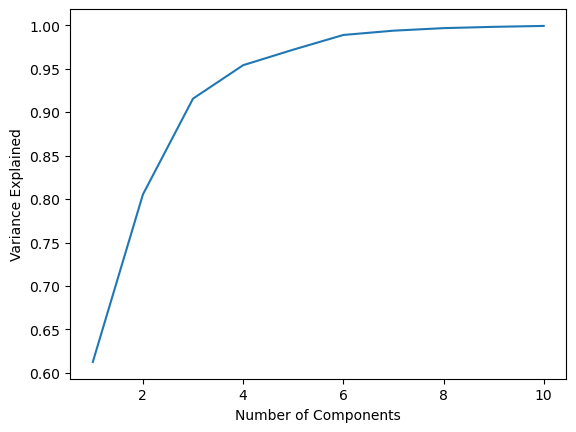

In [26]:
explained_variance = []

for n in range(1,11):
    pca = PCA(n_components=n)
    pca.fit(scaled_X)
    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

plt.plot(range(1,11), explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained");

In [27]:
#pca.n_components_
#pca.components_.shape

In [28]:
# Relatie tussen PCA en features:
pca_comp = pd.DataFrame(pca.components_, index=['PC1','PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
pca_comp.columns = col_trans.get_feature_names_out()   # Replace generated column headers with actual feature names
pca_comp.head()

#plt.figure(figsize=(20,3),dpi=100)
#sns.heatmap(pca_comp,annot=True)

,num__AGE,num__CONTRACT_TENURE,num__EMPLOYEE_TENURE,cat__GENDER_M,cat__MANAGER_-1,cat__MANAGER_10085,cat__MANAGER_10123,cat__MANAGER_10204,cat__MANAGER_10219,cat__MANAGER_10284,...,remainder__EVOLUTION_BONUS_EXC,remainder__EVOLUTION_BONUS_LANGUAGE,remainder__EVOLUTION_BONUS_MISC,remainder__EVOLUTION_BONUS_OBJECTIVE,remainder__EVOLUTION_BONUS_SHARING,remainder__EVOLUTION_BONUS_TECHNICAL,remainder__EVOLUTION_BONUS_TOTAL,remainder__EVOLUTION_BONUS_UNEXPECTED,remainder__EVOLUTION_BONUS_WELCOME,remainder__EVOLUTION_BONUS_YIELD
PC1,0.000033,0.000010,0.000046,0.000006,-4.283249e-07,-1.776834e-07,1.872785e-08,-3.960111e-08,6.824309e-09,1.272402e-06,...,-0.0,1.056740e-06,-0.0,0.000127,1.722104e-07,-0.0,0.000031,9.677127e-08,-0.0,-0.000033
PC2,0.000037,0.000065,0.000073,0.000020,-8.912206e-07,-4.408097e-07,1.279750e-06,-3.661271e-08,-4.678715e-07,3.415929e-06,...,0.0,2.189487e-05,0.0,-0.000272,-1.099452e-08,0.0,-0.000191,1.556619e-07,0.0,0.000206
PC3,-0.000041,-0.000023,-0.000055,0.000017,1.618606e-07,-3.255834e-07,3.674689e-07,1.118742e-08,-3.872332e-07,-6.698917e-07,...,-0.0,6.778368e-07,-0.0,0.001005,-1.283625e-07,-0.0,0.001020,-1.955257e-06,-0.0,0.000084
PC4,-0.000074,-0.000093,-0.000116,0.000005,-3.536685e-07,2.351237e-07,4.622702e-06,2.203715e-08,6.028393e-07,8.643811e-07,...,-0.0,-2.029579e-06,-0.0,-0.000361,-1.306363e-07,-0.0,-0.000123,6.447149e-06,-0.0,0.000042
PC5,0.000078,-0.000009,0.000056,-0.000025,2.394061e-06,1.897991e-07,-2.671780e-07,-1.824702e-07,4.786573e-08,1.384588e-05,...,0.0,7.259501e-05,0.0,0.001226,2.256120e-08,0.0,-0.000015,3.512269e-06,0.0,-0.000524


In [29]:
# Explained variance mee in rekening brengen bij correlatie van de features
display(pca.explained_variance_ratio_)

pca_w = pca_comp.mul((pca.explained_variance_ratio_), axis='index').copy()

## Normaliseren
#pca_w = pca_w / pca_w.sum().abs().sum()   # Totaal van alle PCA correlaties op 1 brengen


array([0.61267989, 0.19262001, 0.11020728, 0.03844594, 0.01784061,
       0.01691892, 0.00493564, 0.00292284, 0.00148532, 0.00105762])

In [30]:
pca_wabs = pca_w.abs().copy()

# Calculate total correlation per feature rather than by OneHotEncoder split
lst_cum = ['MANAGER', 'DEPARTMENT', 'DPT_CHANGE_FLAG', 'COMPANY', 'SITE', 'FULL_TIME', 'EMPLOYEE_LEVEL', 'HANDICAP', 'CITIZENSHIP']
for col in lst_cum:
    prefix = 'cat__' + col

    # Add column with total correlation
    pca_wabs[col] = pca_wabs.filter(regex=prefix, axis='columns').sum(axis='columns')

    # Remove columns with correlations for individual OneHotEncoder splits
    fltr = filter(lambda x: x.startswith(prefix), pca_wabs.columns)
    pca_wabs.drop(list(fltr), axis='columns', inplace=True)

# Remove prefixes from column names
dict_colnames = {}
for i, col in enumerate(pca_wabs.columns):
    if col.find('__') > 0:
        dict_colnames[col] = col[ (col.find('__')+2) : ]

pca_wabs.rename(columns=dict_colnames, inplace=True)

display(pca_wabs.head())


,AGE,CONTRACT_TENURE,EMPLOYEE_TENURE,GENDER_M,EMPLOYEE_TYPE_EMP,JOB_CLIENT AVISOR,STATUS_A,PERMANENT_R,EMPLOYEE_CLASS_INT,SUM_BONUS_UNEXPECTED_3Mago,...,EVOLUTION_BONUS_YIELD,MANAGER,DEPARTMENT,DPT_CHANGE_FLAG,COMPANY,SITE,FULL_TIME,EMPLOYEE_LEVEL,HANDICAP,CITIZENSHIP
PC1,0.000020,6.361017e-06,0.000028,3.966697e-06,0.0,0.0,0.0,1.628926e-06,2.262265e-08,0.000116,...,0.000020,0.000079,0.000065,4.211346e-06,0.000030,0.000036,7.563171e-06,0.000035,3.598044e-07,1.535778e-06
PC2,0.000007,1.245195e-05,0.000014,3.871922e-06,0.0,0.0,0.0,5.600206e-07,5.472796e-09,0.000091,...,0.000040,0.000052,0.000046,2.785102e-06,0.000020,0.000022,3.220903e-06,0.000015,6.271640e-08,8.623192e-07
PC3,0.000005,2.578109e-06,0.000006,1.855288e-06,0.0,0.0,0.0,2.857625e-08,4.131875e-08,0.000226,...,0.000009,0.000018,0.000012,5.177436e-07,0.000006,0.000009,3.818409e-07,0.000008,9.724500e-08,3.084445e-07
PC4,0.000003,3.567021e-06,0.000004,1.864936e-07,0.0,0.0,0.0,2.088333e-07,3.438184e-10,0.000442,...,0.000002,0.000015,0.000013,2.617677e-07,0.000007,0.000011,7.865140e-07,0.000006,2.671785e-08,5.145095e-07
PC5,0.000001,1.652718e-07,0.000001,4.453240e-07,0.0,0.0,0.0,1.461743e-07,2.803562e-09,0.000336,...,0.000009,0.000008,0.000006,2.539678e-07,0.000002,0.000004,4.313839e-07,0.000001,2.347327e-08,1.736771e-07


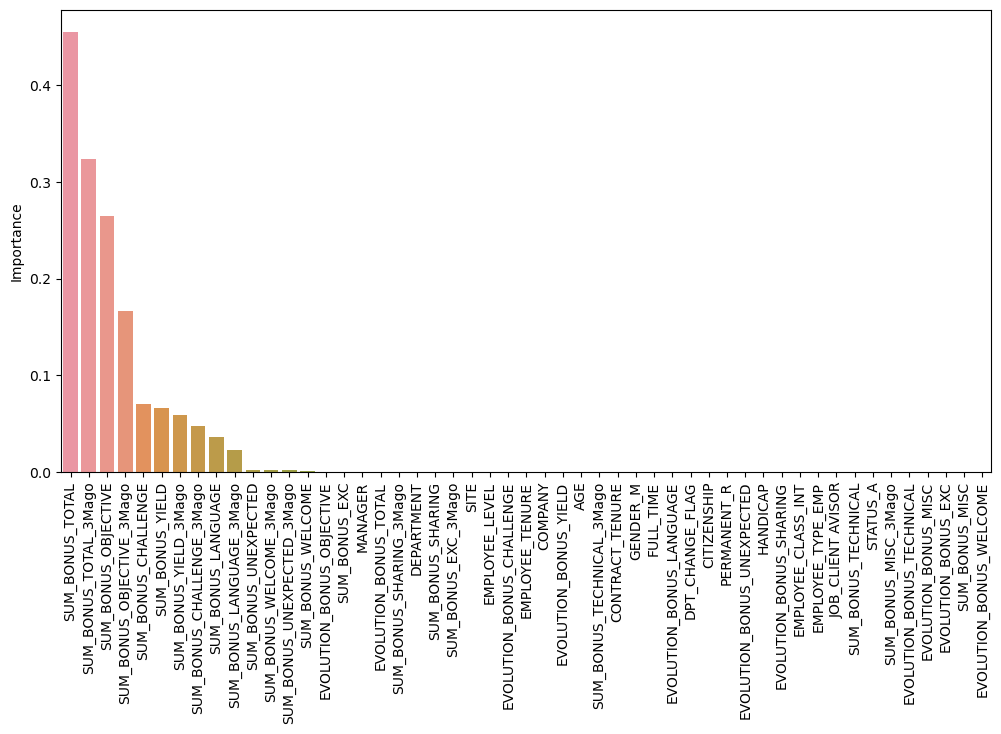

In [32]:
# DF opbouwen met gecumuleerde feature importances over de 10 PC's
pca_feat_imp = pd.DataFrame(data={'Importance' : pca_w.sum()}, index=col_trans.get_feature_names_out())

# Features aggregeren (undo OneHotEncoding)
pca_feat_imp = agg_feat_imp(pca_feat_imp)

# Features plotten volgens afnemend belang
plot_feat_imp(pca_feat_imp, export=True, file_name='../Output/FeatureImportance_PrincipalComponents.jpg')

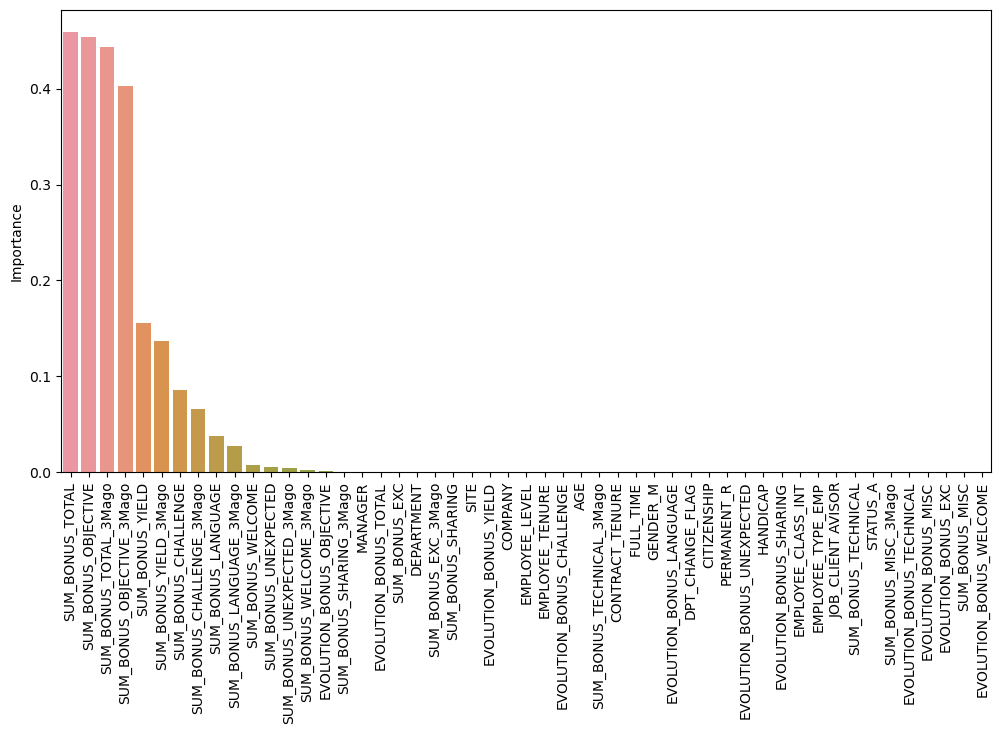

In [33]:
# Features sorteren volgens afnemend gecumuleerd belang over de 10 PC
pca_feat_imp = pd.DataFrame(data={'Importance' : pca_wabs.sum()}, index=pca_wabs.columns)
pca_feat_imp.sort_values('Importance', ascending=False, inplace=True)

plt.figure(figsize=(12,6),dpi=100)
sns.barplot(pca_feat_imp, x=pca_feat_imp.index, y=pca_feat_imp['Importance'])
plt.xticks(rotation=90);

### Random Forest

In [34]:
switch_rfc = False

if switch_rfc:
    n_estimators=[100, 128, 15, 200, 250, 300, 350]
    max_features= [2, 4, 6, 8, 10]
    bootstrap = [True]
    oob_score = [True]   # oob_score heeft geen impact op performantie, geeft enkel idee van accuraatheid van model
    # Best params na 1e run: {'bootstrap': True, 'max_features': 8, 'n_estimators': 128, 'oob_score': True}

    param_grid = {'n_estimators':n_estimators,
                'max_features':max_features,
                'bootstrap':bootstrap,
                'oob_score':oob_score}  # oob_score is enkel zinvol indien bootstrap=True anders zal de fit failen

    rfc = RandomForestClassifier()
    grid = GridSearchCV(rfc,param_grid)
    grid.fit(scaled_X, y)

    display(grid.best_params_)   # parameters beste estimator

In [35]:
# aanmaken beste model met oob_score:
rfc = RandomForestClassifier(max_features=8, n_estimators=300, oob_score=True)
rfc.fit(scaled_X, y)
rfc.oob_score_   # oob_score is tegenovergestelde van OOB error !

0.858139534883721

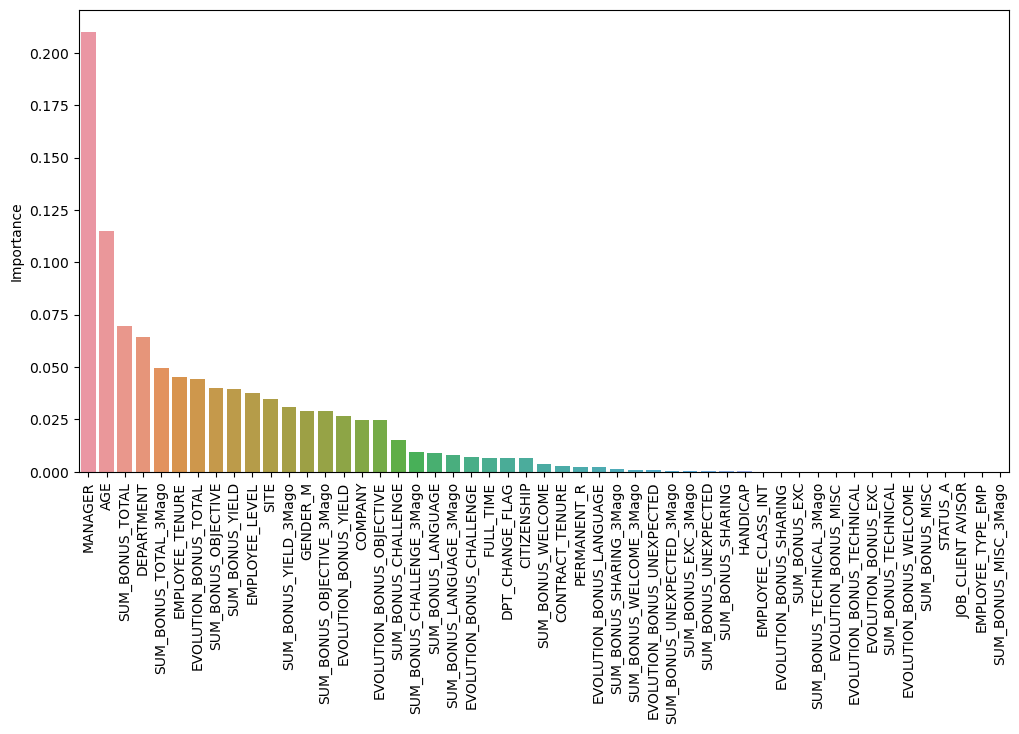

In [36]:
# DF opbouwen met feature importances
rfc_feat_imp = pd.DataFrame(data={'Importance' : rfc.feature_importances_}, index=col_trans.get_feature_names_out())

# Features aggregeren (undo OneHotEncoding)
rfc_feat_imp = agg_feat_imp(rfc_feat_imp)

# Features plotten volgens afnemend belang
plot_feat_imp(rfc_feat_imp, export=True, file_name='../Output/FeatureImportance_RandomForest.jpg')

### Gradient boosting

In [37]:
switch_gb = False
if switch_gb:
    n_est = [80, 100, 150, 200, 300]
    max_f = [6, 8, 10]
    max_d = [4, 5, 6]
    l_rate = [0.02, 0.05, 0.1]
    # Best params na 1e run: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 8, 'n_estimators': 100}
    # Best params na 2e run: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 6, 'n_estimators': 200}

    param_grid = {'n_estimators': n_est,
                'max_features': max_f,
                'max_depth': max_d,
                'learning_rate': l_rate}

    gbc = GradientBoostingClassifier()
    grid = GridSearchCV(gbc, param_grid)
    grid.fit(scaled_X, y)

    display(grid.best_params_)   # parameters beste estimator

In [38]:
gbc = GradientBoostingClassifier(learning_rate= 0.05, max_depth= 5, max_features= 8, n_estimators= 200)
gbc.fit(scaled_X, y)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, max_features=8,
                           n_estimators=200)

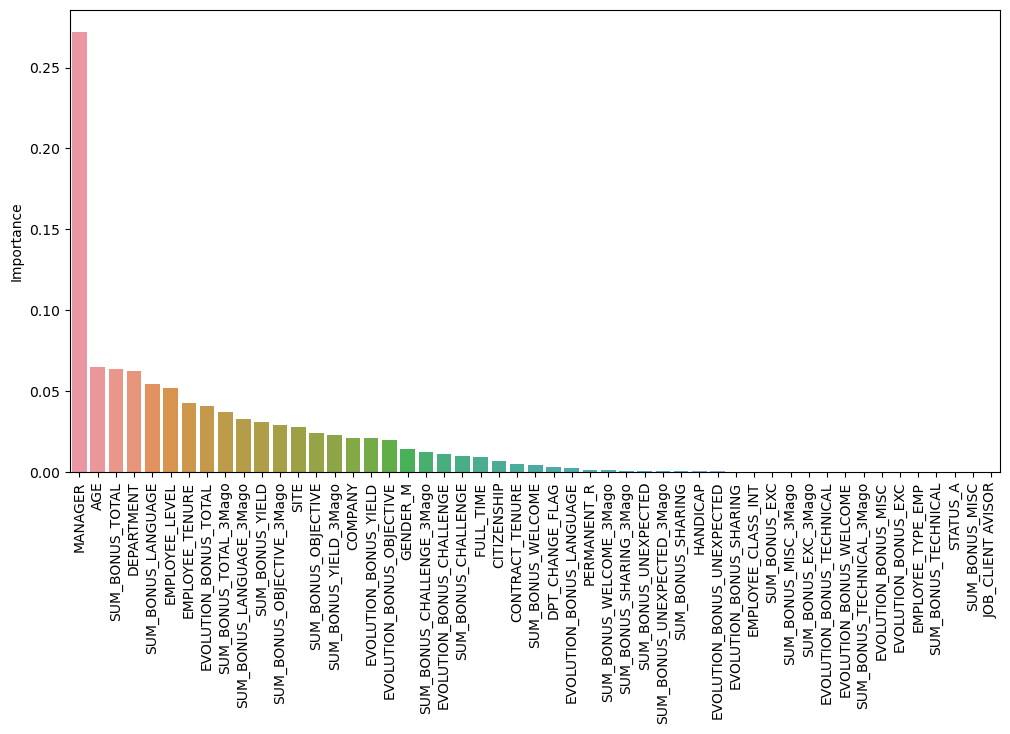

In [39]:
# DF opbouwen met feature importances
gbc_feat_imp = pd.DataFrame(data=gbc.feature_importances_, index=col_trans.get_feature_names_out(), columns=['Importance'])

# Features aggregeren (undo OneHotEncoding)
gbc_feat_imp = agg_feat_imp(gbc_feat_imp)

# Features plotten volgens afnemend belang
plot_feat_imp(gbc_feat_imp, export=True, file_name='../Output/FeatureImportance_GradientBoosting.jpg')

### Check correlation between bonuses

In [42]:
# Create separate dataframes with bonuses
df_3m_bonus = pd.DataFrame()
df_sumbonus = pd.DataFrame()
df_evobonus = pd.DataFrame()

for col in amt_feat:
    if 'SUM_BONUS' in col:
        if '3Mago' in col:
            df_3m_bonus[col] = df_train[col]
        else:
            df_sumbonus[col] = df_train[col]
    if 'EVOLUTION' in col:
        df_evobonus[col] = df_train[col]


In [43]:
# Check for bonus columns with only values = 0 & remove them
switch_del_col_0 = False

if switch_del_col_0:
    print(len(df_3m_bonus.columns))
    zero_cols = df_3m_bonus.columns[(df_3m_bonus == 0).all()]
    df_3m_bonus.drop(labels=zero_cols, axis=1, inplace=True)
    print(len(df_3m_bonus.columns))

    print(len(df_sumbonus.columns))
    zero_cols = df_sumbonus.columns[(df_sumbonus == 0).all()]
    df_sumbonus.drop(labels=zero_cols, axis=1, inplace=True)
    print(len(df_sumbonus.columns))

    print(len(df_evobonus.columns))
    zero_cols = df_evobonus.columns[(df_evobonus == 0).all()]
    df_evobonus.drop(labels=zero_cols, axis=1, inplace=True)
    print(len(df_evobonus.columns))

,UNEXPECTED,WELCOME,CHALLENGE,MISC,EXC,LANGUAGE,SHARING,OBJECTIVE,YIELD,TECHNICAL,TOTAL
UNEXPECTED,1.000000,-0.010693,-0.016315,nan,-0.002525,-0.009547,-0.003000,-0.033597,-0.053912,nan,0.011656
WELCOME,-0.010693,1.000000,-0.037417,nan,-0.004880,0.004012,-0.005797,-0.061341,-0.083666,nan,-0.047248
CHALLENGE,-0.016315,-0.037417,1.000000,nan,0.068304,-0.028041,-0.008303,-0.051633,0.146450,nan,0.341412
MISC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
EXC,-0.002525,-0.004880,0.068304,nan,1.000000,-0.004356,-0.001369,-0.020557,0.022747,nan,0.020413
LANGUAGE,-0.009547,0.004012,-0.028041,nan,-0.004356,1.000000,-0.005176,-0.076525,0.133702,nan,0.223731
SHARING,-0.003000,-0.005797,-0.008303,nan,-0.001369,-0.005176,1.000000,0.029192,-0.025413,nan,0.017106
OBJECTIVE,-0.033597,-0.061341,-0.051633,nan,-0.020557,-0.076525,0.029192,1.000000,-0.390579,nan,0.728927
YIELD,-0.053912,-0.083666,0.146450,nan,0.022747,0.133702,-0.025413,-0.390579,1.000000,nan,0.218607
TECHNICAL,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


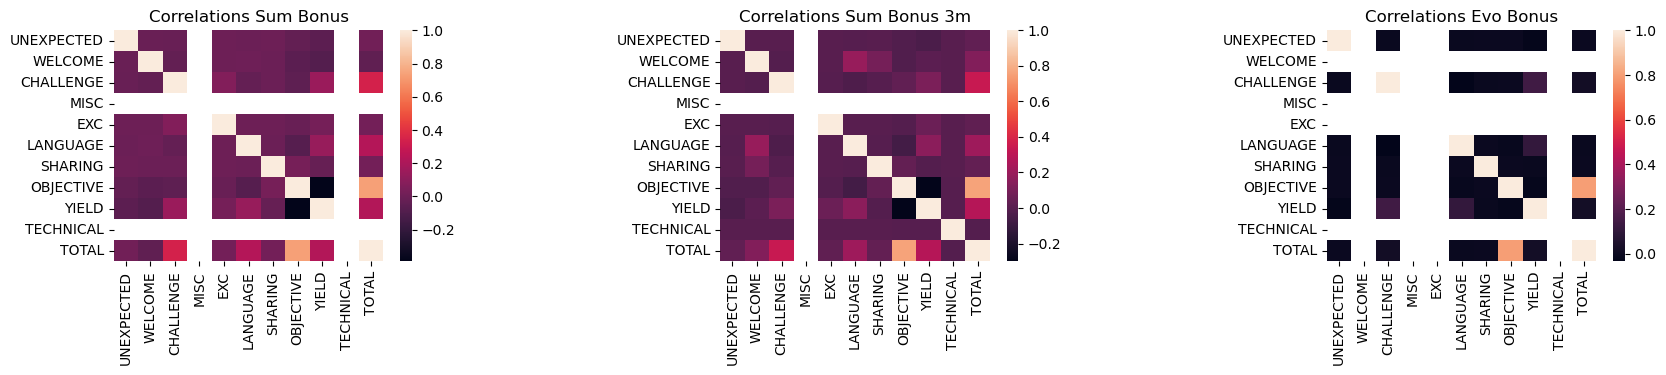

In [57]:
# Bonus correlation matrices
df_sumcorr = df_sumbonus.corr()
df_3m_corr = df_3m_bonus.corr()
df_evocorr = df_evobonus.corr()

# Trim column headers
df_sumcorr.rename(columns=lambda x: x.removeprefix('SUM_BONUS_'), inplace=True)
df_3m_corr.rename(columns=lambda x: x.removeprefix('SUM_BONUS_'), inplace=True)
df_3m_corr.rename(columns=lambda x: x.removesuffix('_3Mago'), inplace=True)
df_evocorr.rename(columns=lambda x: x.removeprefix('EVOLUTION_BONUS_'), inplace=True)

# Trim index
df_sumcorr.rename(index=lambda x: x.removeprefix('SUM_BONUS_'), inplace=True)
df_3m_corr.rename(index=lambda x: x.removeprefix('SUM_BONUS_'), inplace=True)
df_3m_corr.rename(index=lambda x: x.removesuffix('_3Mago'), inplace=True)
df_evocorr.rename(index=lambda x: x.removeprefix('EVOLUTION_BONUS_'), inplace=True)

# Sort DF rows identically
df_3m_corr = df_3m_corr.reindex(labels=df_sumcorr.columns.tolist())
df_evocorr = df_evocorr.reindex(labels=df_sumcorr.columns.tolist())

# Sort DF columns identically
df_3m_corr = df_3m_corr[df_sumcorr.columns.tolist()]
df_evocorr = df_evocorr[df_sumcorr.columns.tolist()]

# Print correlation matrices in a single row
from IPython.display import display_html 
df1_styler = df_sumcorr.style.set_table_attributes("style='display:inline', margin-right:20px;'").set_caption('Correlations Sum Bonus')
df2_styler = df_3m_corr.style.set_table_attributes("style='display:inline', margin-right:20px;'").set_caption('Correlations 3m Bonus')
df3_styler = df_evocorr.style.set_table_attributes("style='display:inline'").set_caption('Correlations Evo Bonus')
display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_(), raw=True)

# Print correlation heatmaps in single row
fig, axes = plt.subplots(figsize=(20,3), dpi=100, nrows=1, ncols=3)
sns.heatmap(df_sumcorr, ax=axes[0])   # annot=True, 
sns.heatmap(df_3m_corr, ax=axes[1])   # annot=True, 
sns.heatmap(df_evocorr, ax=axes[2])   # annot=True, 
axes[0].set_title('Correlations Sum Bonus')
axes[1].set_title('Correlations Sum Bonus 3m')
axes[2].set_title('Correlations Evo Bonus')
plt.subplots_adjust(wspace=0.8)
plt.show();

In [65]:
# Trim column headers
df_sumbonus.rename(columns=lambda x: x.removeprefix('SUM_BONUS_'), inplace=True)
df_3m_bonus.rename(columns=lambda x: x.removeprefix('SUM_BONUS_'), inplace=True)
df_3m_bonus.rename(columns=lambda x: x.removesuffix('_3Mago'), inplace=True)
#df_evocorr.rename(columns=lambda x: x.removeprefix('EVOLUTION_BONUS_'), inplace=True)

df_sumbonus.corrwith(df_3m_bonus, axis='index')

UNEXPECTED    0.826801
WELCOME      -0.006940
CHALLENGE     0.763100
MISC               NaN
EXC          -0.001106
LANGUAGE      0.877678
SHARING       0.582969
OBJECTIVE     0.746593
YIELD         0.801099
TECHNICAL          NaN
TOTAL         0.680898
dtype: float64

In [ ]:
df_train_condensed = df_train.copy()
# Ignore names
df_train_condensed.drop(['NAME', 'FIRST_NAME'], axis=1, inplace=True)
# Drop columns with only a single value
df_train_condensed.drop(['EMPLOYEE_TYPE', 'JOB', 'STATUS'], axis=1, inplace=True)
# Ignore bonus details
for col in df_train_condensed.columns:
    if ( 'SUM_BONUS' in col or 'EVOLUTION_BONUS' in col ) and not 'TOTAL' in col:
        del df_train_condensed[col]
df_train_condensed.head()
#sns.pairplot(df_train_condensed,diag_kind='hist')

### Train | Test Split en Scaling

In [ ]:
X = df_train.drop('Target_Churn',axis=1)
X = X.drop(['Employee ID', 'NAME', 'FIRST_NAME'], axis='columns')
y = df_train['Target_Churn']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train.info()

In [ ]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Maken van het Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_model = LogisticRegression()

In [ ]:
log_model.fit(scaled_X_train,y_train)

In [ ]:
log_model.coef_

In [ ]:
df.head()

### Model Performantie voor Classificatie

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, ConfusionMatrixDisplay

In [ ]:
y_pred = log_model.predict(scaled_X_test)

In [ ]:
# herinner de accuracy paradox: we willen niet alleen op deze metric vertrouwen!
accuracy_score(y_test,y_pred)

In [ ]:
# Idem: confusion matrix, maar mooi geplot - Ruwe waarden
cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_model.classes_)
disp.plot()

In [ ]:
# Confusion matrix, genormaliseerd met normalize = true: 
# Dit is normalisatie over rijen, dus over de echte labels.  Normalisatie betekent dat de waarden in de rij
# zullen worden genormaliseerd om samen een som van 1 te bekomen (100%)

# Elke rij in de confusion matrix zal de proportie predicties voor de respectieve echte klasse weergeven.
# Dit geeft, voor elke echte klasse (0 / 1), welke proportie van de samples voor elke klasse werden voorspeld
# Concreet: de eerste rij geeft weer dat, van alle echte klasse 0 samples, 89% correct werd voorspeld, en 11% 
# foutief aan klasse 1 werden toegekend.
# De tweede rij geeft aan dat 5% van de echte klasse 1 samples foutief als klasse 0 werden voorspeld, en 95% juist.

cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_model.classes_)
disp.plot()

In [ ]:
# Confusion matrix, genormaliseerd met normalize = pred: 
# Dit is een normalisatie op kolom, dus normalisatie zodat de som van de predicties per klasse 1 geven (dus over kolommen) 
# Concreet voor elke kolom: de waarden representeren de proportie van die voorspelde klasse die tot elke werkelijke klasse behoren.
# Maw: het leert ons, voor een gegeven voorspelde klasse, welk percentage van de voorspellingen correct waren, en welk % misclassificaties
# van andere klasses waren.

cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_, normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_model.classes_)
disp.plot()

In [ ]:
# Confusion matrix, genormaliseerd met normalize = all: 
# Dit is een normalisatie op totaal van de samples.  Elke waarde in de cm zal worden gedeeld door het totaal aantal
# samples om zo de proportie van het totaal weer te geven, en dus de proportie True Negatives etc...

cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_, normalize='all')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_model.classes_)
disp.plot()

In [ ]:
# Precision, Recall en F1-score:
# vergeet het print statement niet hier...
print(classification_report(y_test,y_pred))

### Als je enkel precision en recall wil: 

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision_score(y_test, y_pred)

In [ ]:
recall_score(y_test, y_pred)

### Als je een voorspelling voor een punt wil

In [ ]:
log_model.predict_proba(scaled_X_test)[0]

In [ ]:
# werkelijke waarde
y_test[0]

## Evaluating Curves and AUC

**Make sure to watch the video on this!**

In [ ]:
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay,RocCurveDisplay

In [ ]:
# tradeoff tussen precision en recall visualiseren:
fig, ax = plt.subplots(figsize=(12,8), dpi=200)
y_prob = log_model.predict_proba(scaled_X_test)
y_prob = y_prob[:,1] # enkel kans klasse 1
precision, recall, _ = precision_recall_curve(y_test, y_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax)

In [ ]:
# ROC curve
fig, ax = plt.subplots(figsize=(12,8), dpi=200)
RocCurveDisplay.from_estimator(log_model, scaled_X_test, y_test, ax=ax)

------
------